INFO-H-515 Project <br>
2022–2023

# Phase 1 : Batch Processing
Dimitris Sacharidis, Antonios Kontaxakis <br>
EPB, ULB 

### Information
Group Number : 5 <br>
Group Members : Rania Baguia (000459242), Hakim Amri (000459153), Julian Cailliau (000459856), Mehdi Jdaoudi (000457507)

### Imports

In [1]:
from pyspark.sql import functions as F 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, LongType, DecimalType, FloatType
from pyspark.sql.window import Window
import logging
import numpy as np
import os
import socket
import time
import math
logging.basicConfig(level=logging.INFO)

### Introduction

Before running this notebook :
- Follow the steps in the preprocessing.ipynb

Otherwise the code are at risk of failure or providing unexpected resutls during the execution.

### Spark Session

In [2]:
spark = SparkSession \
    .builder \
    .master("local[10]")\
    .config("spark.executor.instances", "1") \
    .config("spark.executor.cores", "10") \
    .config("spark.executor.memory", "16G") \
    .appName("BatchProcessor") \
    .getOrCreate()

# Let us retrieve the sparkContext object
sc=spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/14 17:39:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Key notebook variables

Be carefull, in our preprocessing, we added a column called timestamp which is an index per sensor. Please go through the preprocessing to be able to run the file flawlessly.

In [3]:
FILE_PATH:str = "bike_counts.csv"

### Reading the data

In [4]:
bike_counts_rdd = sc.textFile(FILE_PATH)\
    .map(lambda x: x.split(','))\
    .filter(lambda x: x[0] != "Date")

### Computing Covariances

In [5]:
def CorrelationComputation(
    input_data, bidirectionnal: bool = False, N_sensors: int = 18
):
    """
    Computes correlations based on the input data.

    Args:
        input_data: The input data to compute correlations.
        bidirectionnal (bool): Flag indicating whether to consider bidirectional correlations.
        N_sensors (int): The number of sensors.

    Returns:
        The computed correlations at every time t.
    """
    def compute_cum_counts(group):
        """
        Computes cumulative counts for a group of rows.

        Args:
            group: The group of rows.

        Returns:
            list: The rows with cumulative counts appended.
        """
        group = sorted(group, key=lambda y: y[5])
        cum_count = 0
        cum_count_squared = 0
        result = []
        for row in group:
            cum_count += row[2]
            cum_count_squared += row[2]**2
            result.append((*row, cum_count, cum_count_squared))
        return result

    def productAtForPair(x , bidirectionnal:bool, indexes:list[tuple[int,int]]):
        """
        Computes covariances for pair of sensors at time t.

        Args:
            x: The input tuple containing the sensor data.
            bidirectionnal (bool): Flag indicating whether to consider bidirectional correlations.
            indexes (list): The list of indexes to consider.

        Returns:
            list: The computed covariances for the sensor at time t.
        """
        x = sorted(x[1], key=lambda x: x[4])
        covarianceAtTMatrix = [[(row[4], row[0], row[1], row[5],  row[6], row[7], col[4], col[6], col[7], row[2] * col[2]) for col in x] for row in x]
        if not bidirectionnal:
            covariancePerSensor = [covarianceAtTMatrix[i[0]][i[1]] for i in indexes]
        else :
            covariancePerSensor = [col for row in covarianceAtTMatrix for col in row if col[0]!=col[5]]
        return covariancePerSensor

    def correlation(group):
        """
        Computes correlations at every time for a pair.

        Args:
            group: The data regarding a pair of sensors

        Returns:
            list: The rows with correlations appended.
        """
        cum_ProductAtT = 0
        result = []
        for row in group:
            cum_ProductAtT += row[9]
            try :
                corrUntilT = (row[3] * cum_ProductAtT - row[4] * row[7]) / (math.sqrt(row[3] * row[5] - row[4]**2) * math.sqrt(row[3] * row[8] - row[7]**2))
            except ZeroDivisionError:
                corrUntilT = None
            result.append((*row, cum_ProductAtT, corrUntilT))
        return result

    # Preprocessing
    input_data = input_data\
        .map(lambda x: (x[0], int(x[1]), int(x[2]), int(x[3]), x[4], int(x[5])))
    
    # Computing cumulative sums
    input_data = input_data\
        .map(lambda x: (x[4], x))\
        .groupByKey()\
        .mapValues(compute_cum_counts)\
        .flatMap(lambda x: [i for i in x[1]])
    
    
    # Computing covariance matrix at every time t
    indexes = [(i, j) for i in range(N_sensors) for j in range(N_sensors) if j > i]
    Covariance_Pairs = input_data\
        .map(lambda x: (x[5], x))\
        .groupByKey()\
        .flatMap(lambda x: productAtForPair(x, bidirectionnal, indexes))
    
    # Computing correlations at every time t
    CorrelationsAtT = Covariance_Pairs\
        .map(lambda x : (x[0] + "-" + x[6], x))\
        .groupByKey()\
        .mapValues(lambda x: sorted(x, key=lambda y: y[3]))\
        .mapValues(correlation)\
        .flatMap(lambda x : [i for i in x[1]])\
    
    return CorrelationsAtT

In [6]:
correlation = CorrelationComputation(bike_counts_rdd)

In [7]:
schema = StructType([
    StructField("sensor", StringType(), nullable = False),
    StructField("Date", StringType(), nullable = False),
    StructField("Time Gap", IntegerType(), nullable = False),
    StructField("timestamp", IntegerType(), nullable = False),
    StructField("sensor_CumSum", IntegerType(), nullable = False),
    StructField("sensor_CumSumSquared", IntegerType(), nullable = False),
    StructField("Covariate", StringType(), nullable = False),
    StructField("Covariate_CumSum", IntegerType(), nullable = False),
    StructField("Covariate_CumSumSquared", IntegerType(), nullable = False),
    StructField("ProductAtT", IntegerType(), nullable = False),
    StructField("CumSumProductAtT", IntegerType(), nullable = False),
    StructField("correlation(sensor, covariate, t)", FloatType(), nullable = True)
    ]) 
correlation_df = spark.createDataFrame(correlation,  schema)
correlation_df.show()

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


+------+----------+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
|sensor|      Date|Time Gap|timestamp|sensor_CumSum|sensor_CumSumSquared|Covariate|Covariate_CumSum|Covariate_CumSumSquared|ProductAtT|CumSumProductAtT|correlation(sensor, covariate, t)|
+------+----------+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
| CEK31|2018-12-06|       1|        1|            0|                   0|   CJE181|               0|                      0|         0|               0|                             null|
| CEK31|2018-12-06|       2|        2|            0|                   0|   CJE181|               0|                      0|         0|               0|                             null|
| CEK31|2018-12-06|       3|        3|            0|             

#### Sanity Checks

##### Check boundaries, correlation $\rho$ defined on [-1 : 1]
One property known of the correlation is that the values range between -1 and 1. A check could be to evaluate the values.

In [8]:
correlation_df.filter((F.col("correlation(sensor, covariate, t)") > 1) | (F.col("correlation(sensor, covariate, t)") < -1)).show(10)

+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
|sensor|Date|Time Gap|timestamp|sensor_CumSum|sensor_CumSumSquared|Covariate|Covariate_CumSum|Covariate_CumSumSquared|ProductAtT|CumSumProductAtT|correlation(sensor, covariate, t)|
+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+



##### Bidirectionnality issue
The function `CorrelationComputation()` can compute stricly the upper side of the covariance matrix. However, it can cause an issue when trying to evaluate the correlation between a sensor and a covariate. In fact, as below, if the mentionned the wrong direction of the pair, then no results will be shown. As such  we kept the ability to compute the full matrix in both direction as it can be easier to make analysis without worrying about the pair direction.

In [9]:
correlation_df.where((F.col("Date") == "2018-12-06") & (F.col("sensor") == "CB2105") & (F.col("Covariate") == "CB02411")).show(1000)

+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
|sensor|Date|Time Gap|timestamp|sensor_CumSum|sensor_CumSumSquared|Covariate|Covariate_CumSum|Covariate_CumSumSquared|ProductAtT|CumSumProductAtT|correlation(sensor, covariate, t)|
+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
+------+----+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+



In [10]:
correlation_df.where((F.col("Date") == "2018-12-06") & (F.col("sensor") == "CB02411") & (F.col("Covariate") == "CB2105")).show(1000)

+-------+----------+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
| sensor|      Date|Time Gap|timestamp|sensor_CumSum|sensor_CumSumSquared|Covariate|Covariate_CumSum|Covariate_CumSumSquared|ProductAtT|CumSumProductAtT|correlation(sensor, covariate, t)|
+-------+----------+--------+---------+-------------+--------------------+---------+----------------+-----------------------+----------+----------------+---------------------------------+
|CB02411|2018-12-06|       1|        1|            0|                   0|   CB2105|               0|                      0|         0|               0|                             null|
|CB02411|2018-12-06|       2|        2|            0|                   0|   CB2105|               0|                      0|         0|               0|                             null|
|CB02411|2018-12-06|       3|        3|            0|       

##### Comparing to known libraries
As a final assessment of the results, we compared to a known library `numpy` which also compute the correlation with `np.coercoff`. To make the comparaison easier, we took a pair which start from the beginning of the dataset(2018-12-06).

In [11]:
import pandas as pd
from pandas.core.groupby import DataFrameGroupBy

In [12]:
data = pd.read_csv(FILE_PATH).groupby('sensor')

In [17]:
def get_correlation_t(sensor_1:str, sensor_2:str, df:DataFrameGroupBy, corr_column:str='Count', max_search:int=200) -> list[float]:
    """
    Returns the correlation between two sensors.

    Args:
        sensor_1 (str): The name of the first sensor.
        sensor_2 (str): The name of the second sensor.
        df (DataFrameGroupBy): The grouped DataFrame containing sensor data.
        corr_column (str): The column used for correlation computation.
        max_search (int): The maximum number of data points to consider.

    Returns:
        list[float]: The list of correlations between the two sensors.
    """
    sensor_1_s = data.get_group(sensor_1).sort_values(by="timestamp", ascending=True)[corr_column]
    sensor_2_s = data.get_group(sensor_2).sort_values(by="timestamp", ascending=True)[corr_column]

    correlations = [np.corrcoef(sensor_1_s.iloc[1:i], sensor_2_s.iloc[1:i])[0][1] for i in range(1, (max_search))]

    return correlations

def get_comparaison(searchspace:int, sensor_1, sensor_2, df, spark_df, upper_bound:int=96, date:str="2018-12-06" ):
    """
    Computes the comparison between two sensors.

    Args:
        searchspace (int): The maximum search space.
        sensor_1 (str): The name of the first sensor.
        sensor_2 (str): The name of the second sensor.
        df (DataFrame): The original DataFrame.
        spark_df (DataFrame): The Spark DataFrame.
        upper_bound (int): The upper bound for the correlation.
        date (str): The date to filter the Spark DataFrame.

    Returns:
        list[float]: The comparison results.
    """
    corrT = get_correlation_t(sensor_1, sensor_2, df, max_search=searchspace)
    corrTCustom = spark_df.where((F.col("Date") == date) & (F.col("sensor") == sensor_1) & (F.col("Covariate") == sensor_2) & (F.col("timestamp") < searchspace)).select(F.col("correlation(sensor, covariate, t)")).collect()
    corrTCustom = [getattr(x, 'correlation(sensor, covariate, t)') for x in corrTCustom]
    comparaisons = list(zip(corrTCustom, corrT[:upper_bound]))
    return [(i[0]-i[1]) for i in comparaisons if i[0] != None]

In [19]:
import numpy as np
SEARCH_SPACE = 100
diff = get_comparaison(SEARCH_SPACE, 'CB02411', 'CB2105', df=data, spark_df=correlation_df)
f"The average error is {np.mean(diff)}, with a standard deviation of {np.std(diff)}."

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


'The average error is 7.995310904842464e-05, with a standard deviation of 3.343952054503151e-05.'

As seen just in the above output, the deviation of our own implementation compared to one implemented in `numpy` is very slight as it differers in very small decimals. This can be due to difference in float approximation between spark and numpy.

###  The top-5 most correlated pairs

In [20]:
def get_top_n_pairs(x, n:int=5):
    """
    Retrieves the top N pairs from the input.

    Args:
        x: The input data.
        n (int): The number of top pairs to retrieve.

    Returns:
        The input data with the top N pairs.
    """
    nonNull_corr = [record for record in list(x) if record[11] != None]
    nonNull_corr_sorted = sorted(nonNull_corr, key=lambda y: y[11], reverse=True)
    top = [(i[0], i[6], i[11]) for i in nonNull_corr_sorted][:min((n,len(nonNull_corr)))]
    x = (x[0][1], x[0][2], x[0][3], top)
    return x

Top5PairsPerT = correlation\
    .map(lambda x : (x[3], x))\
    .groupByKey()\
    .mapValues(lambda x : get_top_n_pairs(list(x)))\
    .map(lambda x : list(x[1]))

Top5PairsPerT.take(5)

[['2019-01-25',
  18,
  4818,
  [('CEK049', 'CJM90', 0.7810948380856009),
   ('CB02411', 'CEK049', 0.7481477554382634),
   ('CB02411', 'CJM90', 0.7464221796636834),
   ('CB2105', 'CJM90', 0.7111874527796914),
   ('CB2105', 'CEK049', 0.693596350958823)]],
 ['2019-02-23',
  63,
  7647,
  [('CEK049', 'CJM90', 0.8531256167253),
   ('CB02411', 'CJM90', 0.836445046698628),
   ('CB02411', 'CEK049', 0.8057627603408676),
   ('CB1143', 'CEK049', 0.6849985328963037),
   ('CB1143', 'CJM90', 0.6439088749707157)]],
 ['2019-03-27',
  96,
  10752,
  [('CEK049', 'CJM90', 0.8236266224416635),
   ('CB02411', 'CJM90', 0.7829851436665629),
   ('CB02411', 'CEK049', 0.7705302681471508),
   ('CB1143', 'CEK049', 0.6990037716350388),
   ('CB1599', 'CLW239', 0.6639749740094621)]],
 ['2019-04-15',
  42,
  12522,
  [('CEK049', 'CJM90', 0.8115791191122549),
   ('CB02411', 'CEK049', 0.7752729058487945),
   ('CB02411', 'CJM90', 0.770726231615571),
   ('CB1143', 'CEK049', 0.6958480483794568),
   ('CB1599', 'CLW239', 0

To check with the streaming exercice. The results are matching.

In [13]:
# Filter the RDD
filtered_rdd = Top5PairsPerT.filter(lambda x: x[2] == 17280)

# Print the result
filtered_rdd.collect()

[['2019-06-03',
  96,
  17280,
  [('CEK049', 'CJM90', 0.8091435174283385),
   ('CB02411', 'CEK049', 0.7410423170281322),
   ('CB02411', 'CJM90', 0.7376331123400591),
   ('CB1599', 'CLW239', 0.6887482374975789),
   ('CB2105', 'CEK049', 0.6774306410717481)]]]

### Extra step : Visualisation

This section is an extra section that shows the resutls visually for a specific sensor.

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10), "figure.dpi":300, 'savefig.dpi':300})

In [22]:
observations = 200000
sensor = 'CB02411'
VizData = correlation_df.filter((F.col("sensor") == sensor) & (F.col("timestamp")<= observations)).sort(F.col("timestamp")).select(F.col("sensor"), F.col("Covariate"), F.col("timestamp"), F.col("correlation(sensor, covariate, t)")).toPandas()

[Text(0.5, 1.0, 'Correlation of Sensor CB02411 and its Covariates for 200000 timestamps')]

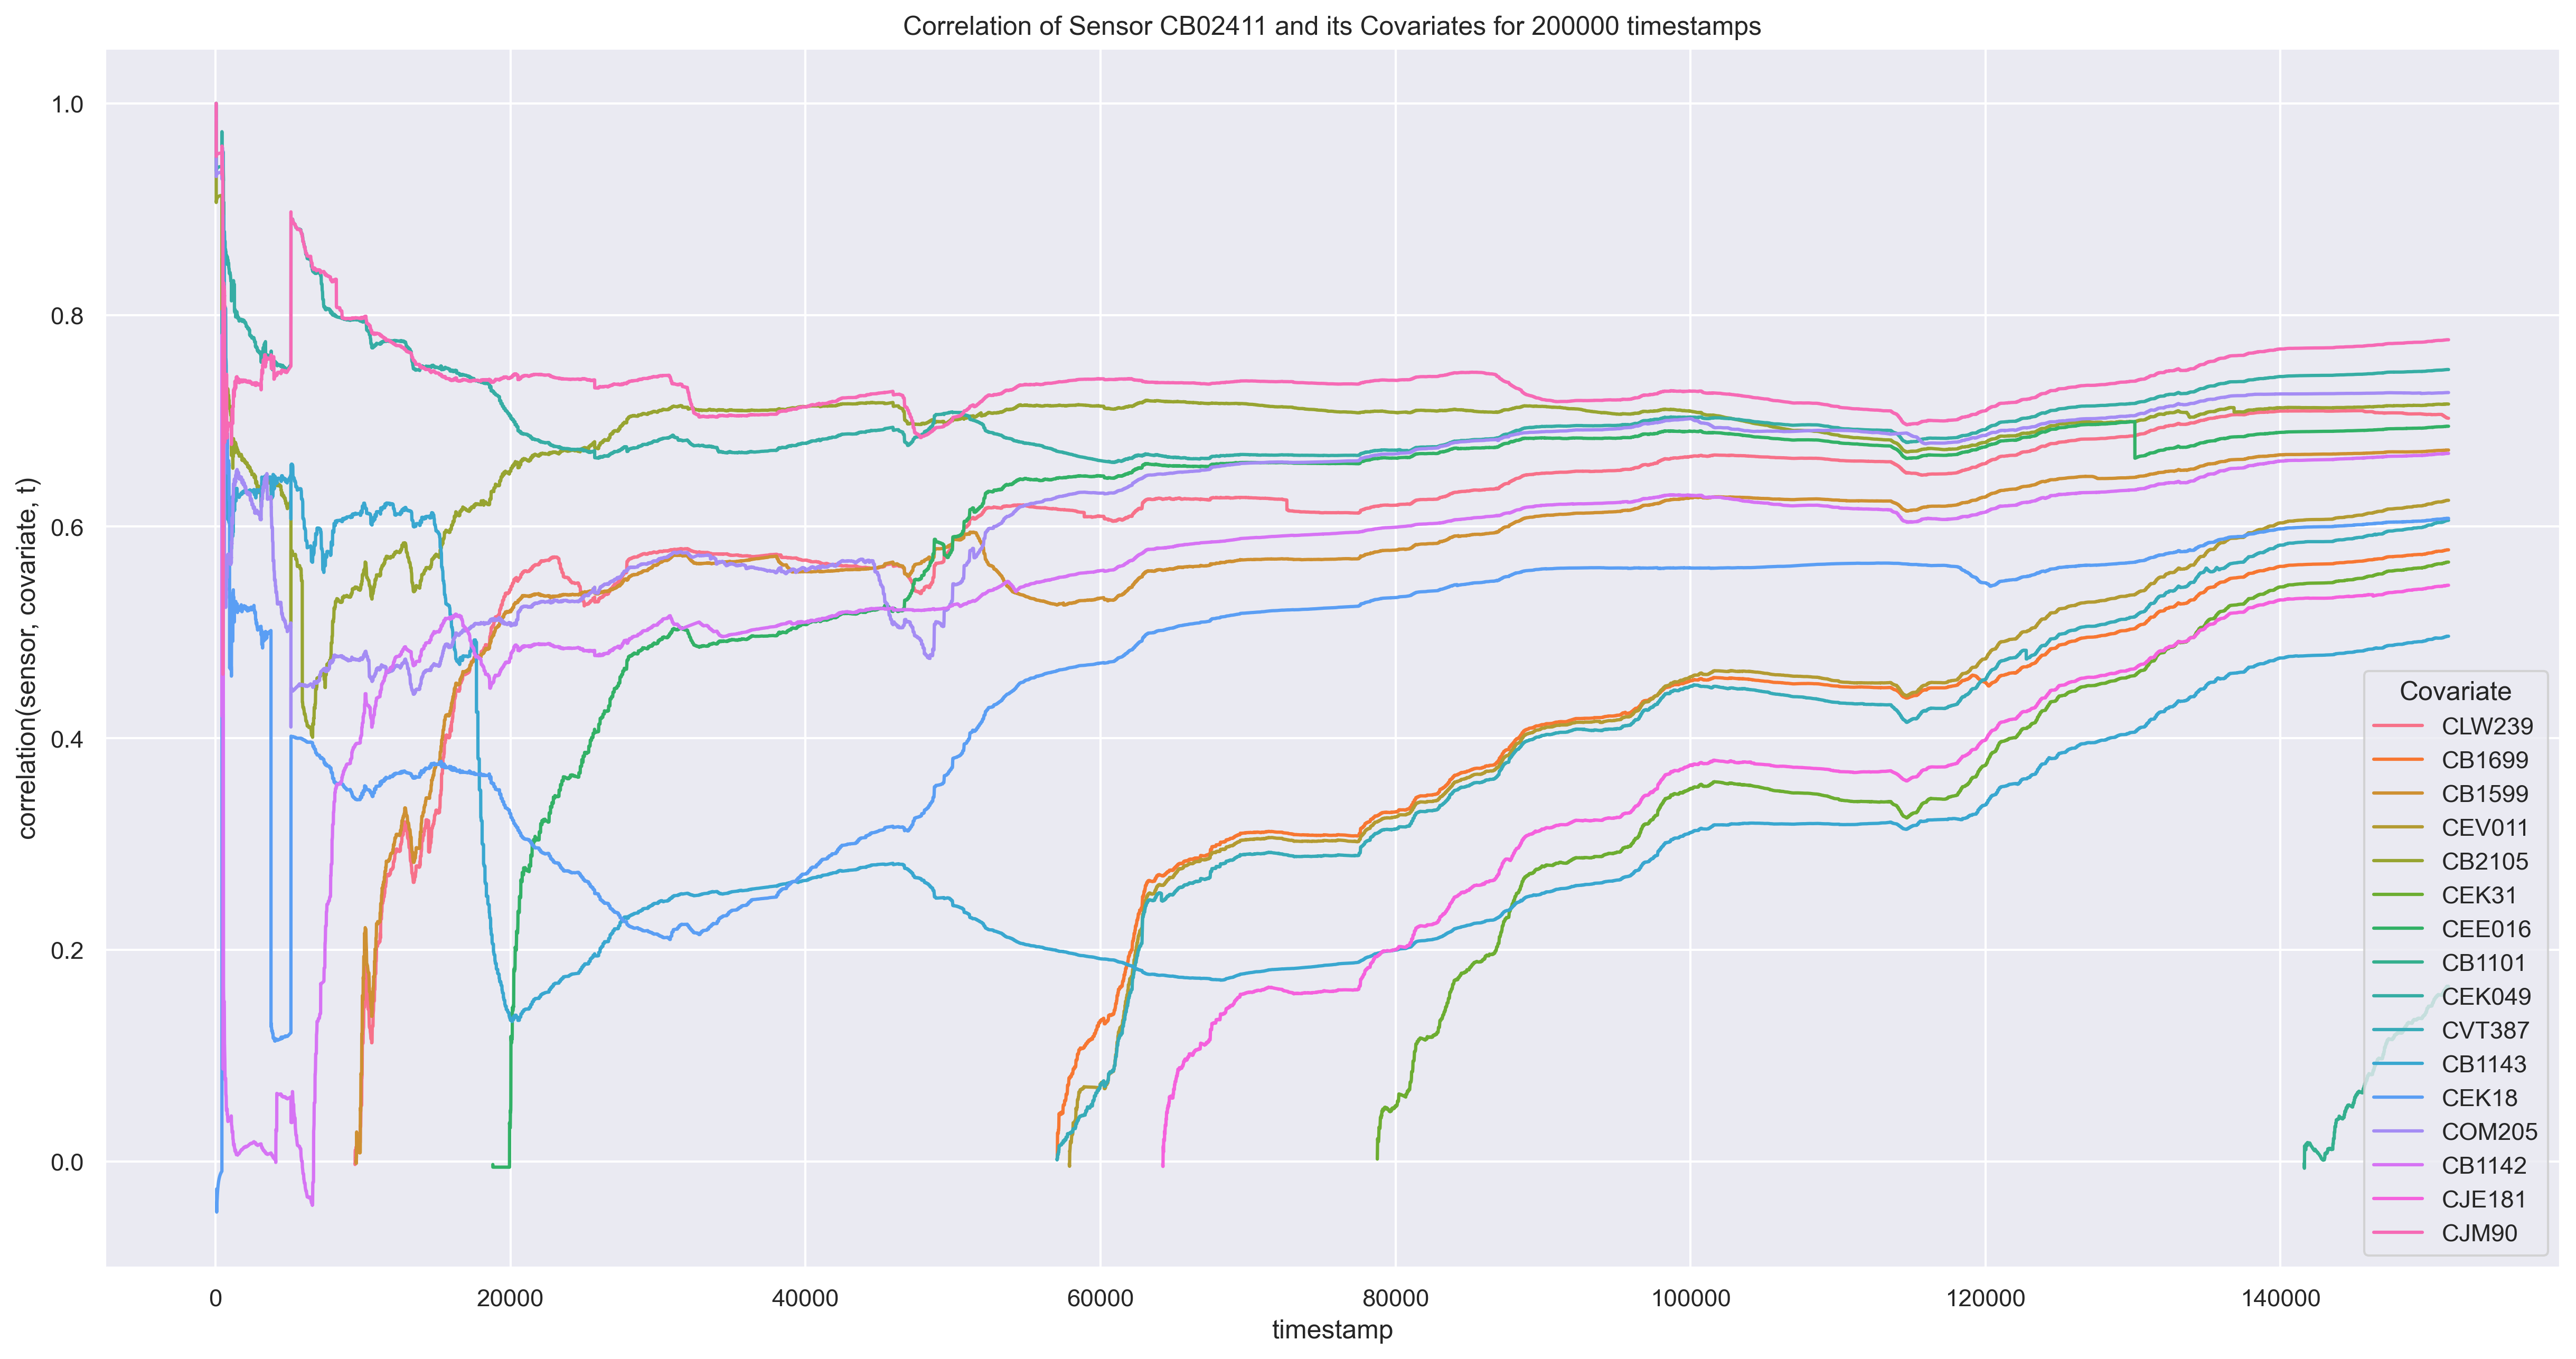

In [23]:
sns.lineplot(x='timestamp', y='correlation(sensor, covariate, t)', hue='Covariate', 
             data=VizData)\
            .set(title=f'Correlation of Sensor {sensor} and its Covariates for {observations} timestamps')

### Stopping the spark session

In [24]:
spark.stop()